In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from google.colab import drive
from transformers import AutoTokenizer, DistilBertModel, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight # <--- For Class Weighting
import matplotlib.pyplot as plt
import seaborn as sns
import os

RNG = 42

# --- MOUNTING GOOGLE DRIVE ---
drive.mount('/content/drive')

# --- LOADING THE DATASET ---

FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/Alpha=1compositve 165k.csv'

print(f"Loading dataset from: {FILE_PATH}")
df = pd.read_csv(FILE_PATH)

# --- SANITY CHECK ---
# The new datasets use 'target_label'. We check for that specific column.
needed_cols = [
    'title', 'reviewText', 'audienceScore', 'tomatoMeter', 'runtimeMinutes',
    'genre', 'language_encoded', 'director_encoded', 'target_label'
]

missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ CRITICAL ERROR: Your CSV is missing these columns: {missing}")

print("--- Part 1: Setup and Data Loading Complete ---")
print(f"Dataset loaded with {df.shape[0]} rows.")
print(f"Target Distribution:\n{df['target_label'].value_counts().sort_index()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.1 MB/s eta 0:00:00
Mounted at /content/drive
Loading dataset from: /content/drive/MyDrive/THESIS 47/Saved Datasets/Alpha=1compositve 165k.csv
--- Part 1: Setup and Data Loading Complete ---
Dataset loaded with 165000 rows.
Target Distribution:
target_label
0    55000
1    55000
2    55000
Name: count, dtype: int64


In [2]:
# --- CLEANING ---
df = df.dropna(subset=['reviewText', 'target_label']).copy()
# Map 'target_label' to the standard 'label' column expected by HF
df['label'] = df['target_label'].astype(int)

class_names = ['Negative', 'Neutral', 'Positive']
N_CLASSES = 3

# Text Prep
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

# --- STRATIFIED SPLIT ---
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

y_train = train_df['label'].values.astype(int)

# ==========================================
# CRITICAL: CALCULATE CLASS WEIGHTS
# ==========================================
# This forces the model to pay attention to minority classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("\n⚖️ Calculated Class Weights (Neg, Neu, Pos):")
print(class_weights)
print("(The model will use these to penalize mistakes on smaller classes more heavily)")

# ==========================================
# FEATURE ENGINEERING (Fit on Train)
# ==========================================

# 1. Numeric
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
train_numeric = train_df[NUMERIC_COLS].copy()
train_medians = train_numeric.median(numeric_only=True)
train_numeric = train_numeric.fillna(train_medians)

scaler = StandardScaler()
scaler.fit(train_numeric.values)

# 2. Categorical: Genre
train_genre_list = train_df['genre'].fillna("Unknown").str.split(', ')
mlb = MultiLabelBinarizer()
mlb.fit(train_genre_list)

# 3. Categorical: Language
import sklearn
from packaging import version
train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

# Handle sklearn version differences
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
else:
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)

ohe_lang.fit(train_lang.to_frame())

# 4. Categorical: Director (Robust Target Encoding)
def director_features_multiclass(train_s, y, test_s, n_splits=5):
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # Frequency
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).values)[:, None].astype(np.float32)

    # K-Fold Target Mean
    n_classes = len(np.unique(y))
    y_ohe = OneHotEncoder(categories=[range(n_classes)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0)

    tr_te = np.zeros((len(s_train), n_classes), dtype=np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        # Compute means
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        # Map to validation
        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        # Fill NaN with global mean
        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values
    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    return tr_freq, te_freq, tr_te, te_te

# Apply Director Encoding
dtr_f, dte_f, dtr_te, dte_te = director_features_multiclass(
    train_df['director_encoded'].astype(str), y_train,
    test_df['director_encoded'].astype(str)
)

dir_train_block = np.concatenate([dtr_f, dtr_te], axis=1).astype(np.float32)
dir_test_block  = np.concatenate([dte_f, dte_te], axis=1).astype(np.float32)

print("--- Part 2: Preprocessing & Weights Complete ---")


⚖️ Calculated Class Weights (Neg, Neu, Pos):
tensor([1., 1., 1.])
(The model will use these to penalize mistakes on smaller classes more heavily)
--- Part 2: Preprocessing & Weights Complete ---


In [3]:
def build_features(split_df, dir_block):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()

    # Numeric
    numeric = split_df[NUMERIC_COLS].copy().fillna(train_medians)
    out['numerical_features'] = scaler.transform(numeric.values).astype(np.float32)

    # Genre
    genre_list = split_df['genre'].fillna("Unknown").str.split(', ')
    out['categorical_features'] = np.concatenate([
        mlb.transform(genre_list),
        ohe_lang.transform(split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown').to_frame()),
        dir_block
    ], axis=1).astype(np.float32)
    return out

train_feats = build_features(train_df, dir_train_block)
test_feats  = build_features(test_df, dir_test_block)

# Dimensions
num_numerical_features = 3
num_categorical_features = train_feats['categorical_features'].shape[1]
print(f"Feature Dims: Numeric={num_numerical_features}, Categorical={num_categorical_features}")

# HF Dataset
raw_datasets = DatasetDict({
    'train': Dataset.from_dict(train_feats),
    'test':  Dataset.from_dict(test_feats),
})

# Tokenization
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_fn(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing...")
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")

print("--- Part 3: Dataset Ready ---")

Feature Dims: Numeric=3, Categorical=50


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing...


Map:   0%|          | 0/132000 [00:00<?, ? examples/s]

Map:   0%|          | 0/33000 [00:00<?, ? examples/s]

--- Part 3: Dataset Ready ---


In [5]:
import torch
import torch.nn as nn
import numpy as np
from transformers import Trainer, TrainingArguments, DistilBertModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- MODEL ARCHITECTURE ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical, num_categorical):
        super().__init__()
        # Ensure MODEL_CHECKPOINT is defined in your environment variables or script
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)

        # Concatenate: BERT Hidden (768) + Numeric (3) + Categorical (N)
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical + num_categorical,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(distilbert_output.last_hidden_state[:, 0])

        combined = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (None, logits)

# --- CUSTOM TRAINER FOR CLASS WEIGHTS ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs[1]

        # CRITICAL: Ensure class_weights is defined in your global scope
        if 'class_weights' in globals():
            weights = class_weights.to(model.classifier.weight.device)
            loss_fct = nn.CrossEntropyLoss(weight=weights)
        else:
            # Fallback if class_weights isn't found, preventing a crash
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# --- DATA COLLATOR ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.stack([f['numerical_features'] for f in features])
        batch['categorical_features'] = torch.stack([f['categorical_features'] for f in features])
        return batch

# --- UPDATED METRICS (THE FIX) ---
def compute_metrics(pred):
    labels = pred.label_ids

    # FIX: Handle both cases where predictions might be a tuple (logits, hidden) or just logits
    if isinstance(pred.predictions, tuple):
        preds_logits = pred.predictions[0]
    else:
        preds_logits = pred.predictions

    # Ensure we are working with numpy arrays and apply argmax on the correct axis
    preds = np.argmax(preds_logits, axis=-1)

    # Use Weighted F1 because we are dealing with potential imbalance
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'f1_weighted': f1, 'precision': prec, 'recall': rec}

# --- INITIALIZATION ---
# Ensure N_CLASSES, num_numerical_features, num_categorical_features are defined
model = MultimodalClassifier(N_CLASSES, num_numerical_features, num_categorical_features)

# Define Save Path
OUTPUT_DIR = f"/content/drive/MyDrive/THESIS 47/Saved Datasets/Model_Results_3Class_Weighted_c-1"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    logging_steps=100
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=MultimodalDataCollator(tokenizer),
    compute_metrics=compute_metrics,
)

print("--- Part 4: Weighted Training Started ---")
trainer.train()
print("--- Training Complete ---")

--- Part 4: Weighted Training Started ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision,Recall
1,0.720300,0.699389,0.670636,0.667800,0.666214,0.670636
2,0.591800,0.700957,0.677818,0.675901,0.674833,0.677818
3,0.480500,0.780206,0.674242,0.672748,0.672017,0.674242


--- Training Complete ---



--- Final Evaluation on Test Set ---


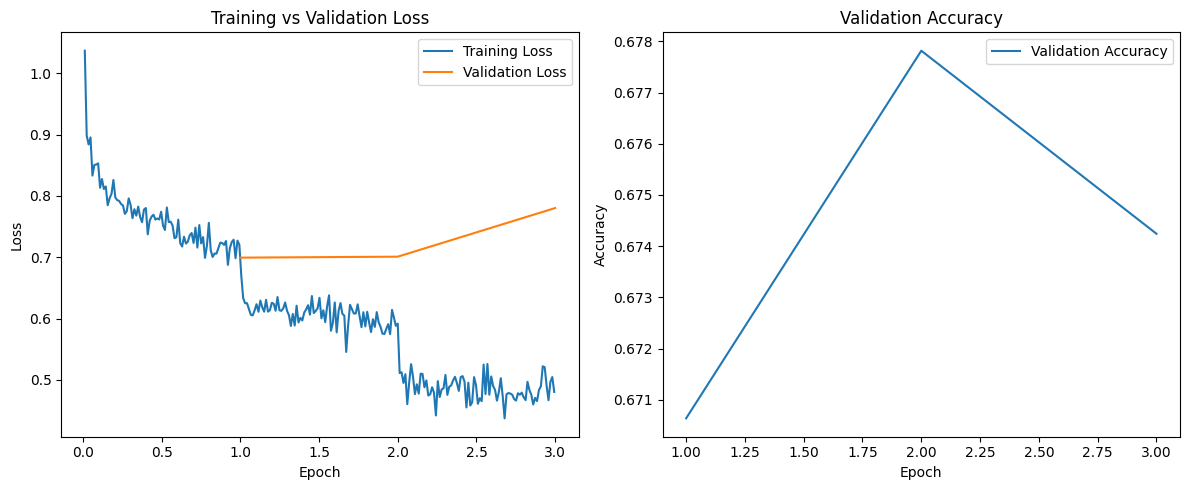

Generating predictions...



--- Classification Report ---
              precision    recall  f1-score   support

    Negative     0.7228    0.7213    0.7220     11000
     Neutral     0.5503    0.5086    0.5286     11000
    Positive     0.7256    0.7820    0.7527     11000

    accuracy                         0.6706     33000
   macro avg     0.6662    0.6706    0.6678     33000
weighted avg     0.6662    0.6706    0.6678     33000



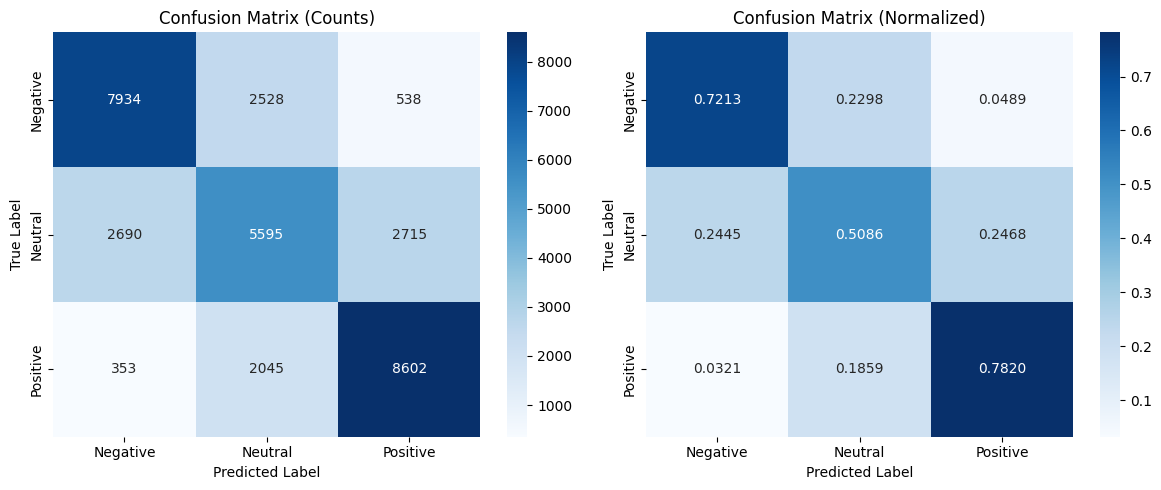

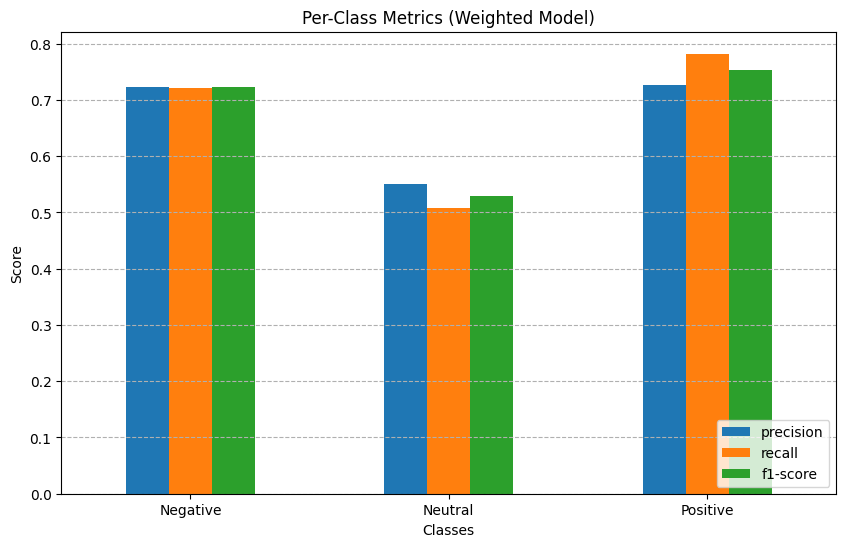


✅ Weighted Model saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/Final_Model_3Class_Composite1


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ==========================
# EVALUATE • REPORT • PLOTS • SAVE
# ==========================
print("\n--- Final Evaluation on Test Set ---")

# 1. PLOT LOSS CURVES
# We access the history from the trainer state
log_history = trainer.state.log_history

# Filter logs for training and evaluation
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)], [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot 2: Accuracy (if available)
plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

# 2. PREDICTIONS (CRITICAL FIX APPLIED HERE)
print("Generating predictions...")
preds_output = trainer.predict(tokenized_datasets["test"])

# --- SAFETY CHECK START ---
# This prevents the "IndexError" or "Shape Mismatch"
if isinstance(preds_output.predictions, tuple):
    logits = preds_output.predictions[0]  # Extract logits if it's a tuple
else:
    logits = preds_output.predictions     # Use directly if it's an array
# --- SAFETY CHECK END ---

# Calculate predicted labels
pred_labels = np.argmax(logits, axis=-1)
true_labels = np.array(tokenized_datasets["test"]["label"])

# 3. CLASSIFICATION REPORT (Updated to 4 decimal places)
print("\n--- Classification Report ---")
report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# ADDED digits=4 here
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# 4. CONFUSION MATRIX (Updated to 4 decimal places)
cm = confusion_matrix(true_labels, pred_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

# Counts
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized
plt.subplot(1, 2, 2)
# CHANGED fmt='.2f' to fmt='.4f' here
sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 5. PER-CLASS BAR CHART
report_df = pd.DataFrame(report_dict).transpose()
# Filter to only show the actual classes (exclude 'accuracy', 'macro avg', etc. for the plot)
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]

ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics (Weighted Model)')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.legend(loc='lower right')
plt.show()

# 6. SAVE
FINAL_MODEL_PATH = f"/content/drive/MyDrive/THESIS 47/Saved Datasets/Final_Model_3Class_Composite1"
trainer.save_model(FINAL_MODEL_PATH)
print(f"\n✅ Weighted Model saved to: {FINAL_MODEL_PATH}")

🔄 Attempting to load BEST model (Epoch 2) from: /content/drive/MyDrive/THESIS 47/Saved Datasets/Model_Results_3Class_Weighted_c-1/checkpoint-16500
✅ Found and loaded model.safetensors
✅ Epoch 2 Model weights loaded and moved to GPU

--- Generating Predictions for Epoch 2 Model ---



--- Classification Report (Epoch 2) ---
              precision    recall  f1-score   support

    Negative     0.7307    0.7149    0.7227     11000
     Neutral     0.5552    0.5286    0.5416     11000
    Positive     0.7386    0.7899    0.7634     11000

    accuracy                         0.6778     33000
   macro avg     0.6748    0.6778    0.6759     33000
weighted avg     0.6748    0.6778    0.6759     33000



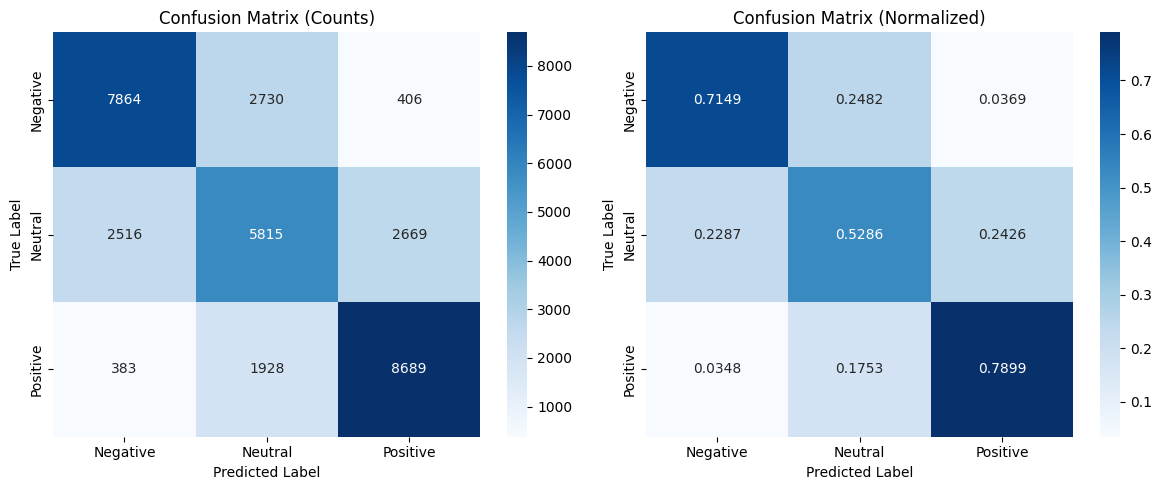


--- Generating Per-Class Metrics Plot ---


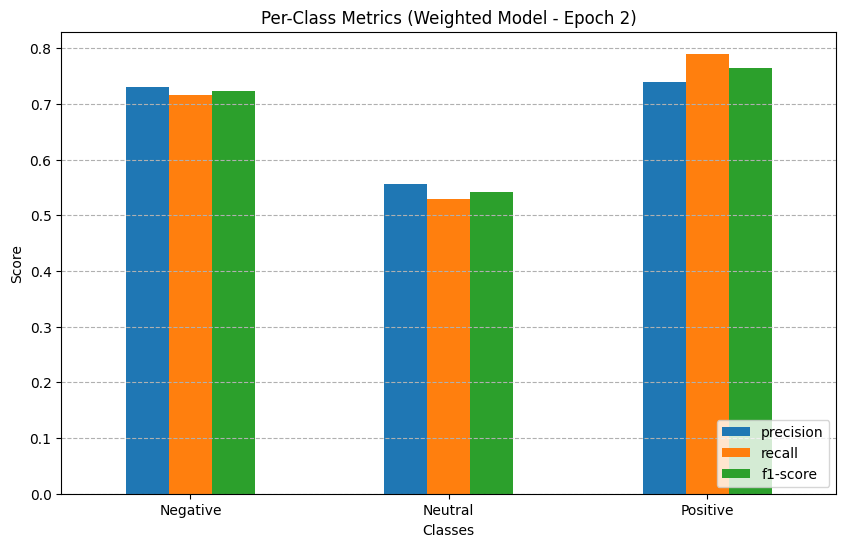


✅ Epoch 2 Weighted Model saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/Final_Model_3Class_Composite1[Best model f1 weighted]


In [7]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer

# ==========================================
# 1. DEFINE THE PATH TO EPOCH 2 (CHECKPOINT-10940)
# ==========================================
# Based on your image, this is the middle checkpoint
EPOCH_2_PATH = "/content/drive/MyDrive/THESIS 47/Saved Datasets/Model_Results_3Class_Weighted_c-1/checkpoint-16500"

print(f"🔄 Attempting to load BEST model (Epoch 2) from: {EPOCH_2_PATH}")

# ==========================================
# 2. LOAD THE WEIGHTS MANUALLY
# ==========================================
# Re-initialize the architecture (Empty shell)
# Ensure N_CLASSES, num_numerical_features, etc. are still defined from your previous cells
model = MultimodalClassifier(N_CLASSES, num_numerical_features, num_categorical_features)

# Check for the weight file (safetensors or pytorch_model.bin)
safe_path = os.path.join(EPOCH_2_PATH, "model.safetensors")
bin_path = os.path.join(EPOCH_2_PATH, "pytorch_model.bin")

if os.path.exists(safe_path):
    from safetensors.torch import load_file
    state_dict = load_file(safe_path)
    print("✅ Found and loaded model.safetensors")
elif os.path.exists(bin_path):
    state_dict = torch.load(bin_path, map_location=torch.device('cpu'))
    print("✅ Found and loaded pytorch_model.bin")
else:
    raise FileNotFoundError(f"❌ Could not find model file in {EPOCH_2_PATH}. Check the path!")

# Load the weights into the model
model.load_state_dict(state_dict)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("✅ Epoch 2 Model weights loaded and moved to GPU")

# ==========================================
# 3. UPDATE TRAINER
# ==========================================
# We swap the current model in the trainer with the loaded one
trainer.model = model

# ==========================================
# 4. RUN FINAL EVALUATION (4-DIGIT PRECISION)
# ==========================================
print("\n--- Generating Predictions for Epoch 2 Model ---")
preds_output = trainer.predict(tokenized_datasets["test"])

# --- SAFETY CHECK ---
if isinstance(preds_output.predictions, tuple):
    logits = preds_output.predictions[0]
else:
    logits = preds_output.predictions

pred_labels = np.argmax(logits, axis=-1)
true_labels = np.array(tokenized_datasets["test"]["label"])

# --- A. CLASSIFICATION REPORT (4 DIGITS) ---
print("\n--- Classification Report (Epoch 2) ---")

# 1. Generate dictionary for the Bar Chart (Step 5)
report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# 2. Print string for the User (Visual Inspection)
# Note: digits=4 ensures 0.6788 formatting
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# --- B. CONFUSION MATRIX (4 DIGITS) ---
cm = confusion_matrix(true_labels, pred_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

# Plot 1: Counts
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 2: Normalized (fmt='.4f' for 4 digits)
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ==========================================
# 5. PER-CLASS BAR CHART (ADDED)
# ==========================================
print("\n--- Generating Per-Class Metrics Plot ---")
report_df = pd.DataFrame(report_dict).transpose()
# Filter to only show the actual classes (exclude 'accuracy', 'macro avg', etc.)
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]

ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics (Weighted Model - Epoch 2)')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.legend(loc='lower right')
plt.show()

# ==========================================
# 6. SAVE THE BEST MODEL (ADDED)
# ==========================================
FINAL_MODEL_PATH = f"/content/drive/MyDrive/THESIS 47/Saved Datasets/Final_Model_3Class_Composite1[Best model f1 weighted]"
trainer.save_model(FINAL_MODEL_PATH)
print(f"\n✅ Epoch 2 Weighted Model saved to: {FINAL_MODEL_PATH}")